In [1]:
# Import machine learning libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import time

print("✓ Machine learning libraries imported!")

✓ Machine learning libraries imported!


In [2]:
# Load the data we saved from the previous notebook
df = pd.read_csv('../data/processed/misinformation_dataset.csv')
print(f"✓ Loaded dataset: {df.shape}")

# Prepare the data for machine learning
X_text = df['text']  # The text we want to analyze
y = df['label']      # The labels (0=real, 1=misinformation)

print(f"✓ Text samples: {len(X_text)}")
print(f"✓ Labels: {len(y)}")

✓ Loaded dataset: (92394, 4)
✓ Text samples: 92394
✓ Labels: 92394


In [3]:
# Convert text to numbers using TF-IDF
print("Converting text to numbers...")
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(X_text)

print(f"✓ Feature matrix shape: {X.shape}")
print("✓ Text converted to numerical features")

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"✓ Training set: {X_train.shape[0]} samples")
print(f"✓ Test set: {X_test.shape[0]} samples")

Converting text to numbers...
✓ Feature matrix shape: (92394, 1000)
✓ Text converted to numerical features
✓ Training set: 73915 samples
✓ Test set: 18479 samples


In [4]:
# Define different machine learning models to compare
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=50, random_state=42),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42)
}

print(f"✓ Defined {len(models)} models to compare")

✓ Defined 3 models to compare


In [5]:
# Train and test all models
results = {}

print("Training models...")
for name, model in models.items():
    print(f"\nTraining {name}...")
    start_time = time.time()
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    training_time = time.time() - start_time
    
    # Store results
    results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'training_time': training_time
    }
    
    print(f"✓ {name}: Accuracy={accuracy:.3f}, F1-Score={f1:.3f}")

print("\n✓ All models trained successfully!")

Training models...

Training Logistic Regression...
✓ Logistic Regression: Accuracy=0.960, F1-Score=0.961

Training Random Forest...
✓ Random Forest: Accuracy=0.972, F1-Score=0.972

Training SVM...
✓ SVM: Accuracy=0.971, F1-Score=0.971

✓ All models trained successfully!


In [6]:
# Create a results table
results_df = pd.DataFrame(results).T
print("=== MODEL COMPARISON RESULTS ===")
print(results_df.round(4))

# Find the best model
best_model = results_df['f1_score'].idxmax()
best_score = results_df.loc[best_model, 'f1_score']
print(f"\n🏆 Best Model: {best_model}")
print(f"🎯 Best F1-Score: {best_score:.4f}")

=== MODEL COMPARISON RESULTS ===
                     accuracy  precision  recall  f1_score  training_time
Logistic Regression    0.9605     0.9609  0.9605    0.9606         0.5361
Random Forest          0.9722     0.9725  0.9722    0.9723       118.6593
SVM                    0.9713     0.9718  0.9713    0.9714     63252.6739

🏆 Best Model: Random Forest
🎯 Best F1-Score: 0.9723


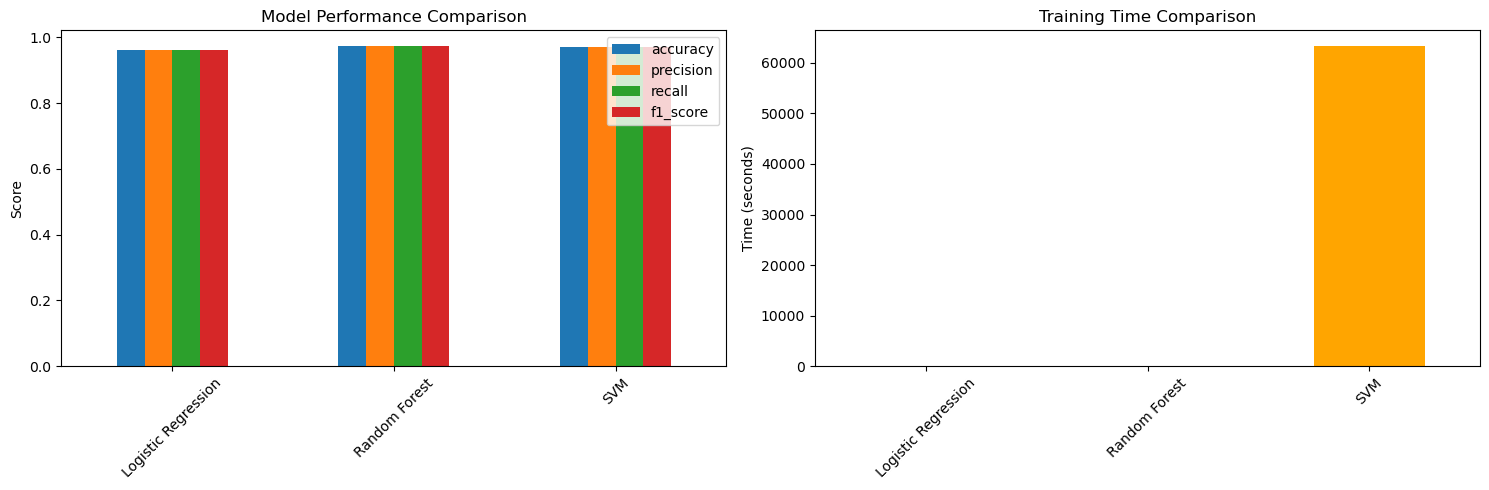

✓ Visualizations created and saved!


In [7]:
# Create visualizations
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 1. Performance comparison chart
results_df[['accuracy', 'precision', 'recall', 'f1_score']].plot(kind='bar', ax=axes[0])
axes[0].set_title('Model Performance Comparison')
axes[0].set_ylabel('Score')
axes[0].legend()
axes[0].tick_params(axis='x', rotation=45)

# 2. Training time comparison
results_df['training_time'].plot(kind='bar', ax=axes[1], color='orange')
axes[1].set_title('Training Time Comparison')
axes[1].set_ylabel('Time (seconds)')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('../results/visualizations/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualizations created and saved!")

In [8]:
# Save all results
import json

# Save results to JSON file
with open('../results/model_results.json', 'w') as f:
    # Convert numpy types to regular Python types for JSON
    results_for_json = {}
    for model_name, metrics in results.items():
        results_for_json[model_name] = {k: float(v) for k, v in metrics.items()}
    json.dump(results_for_json, f, indent=2)

print("✓ Results saved to ../results/model_results.json")

# Save the results table as CSV
results_df.to_csv('../results/model_comparison.csv')
print("✓ Results table saved to ../results/model_comparison.csv")

print("\n🎉 MACHINE LEARNING ANALYSIS COMPLETE!")
print(f"📊 Best performing model: {best_model}")
print(f"📁 All results saved to ../results/ folder")

✓ Results saved to ../results/model_results.json
✓ Results table saved to ../results/model_comparison.csv

🎉 MACHINE LEARNING ANALYSIS COMPLETE!
📊 Best performing model: Random Forest
📁 All results saved to ../results/ folder
